In [1]:
import time
import numpy as np
import pandas as pd
import math
import datetime

import sys
sys.path.append('./src')

from bunch import Bunch
from utils import getDailyResults, getPrecipitationsFromCsv
from config import Configuration
from weather import Weather

In [2]:
class Model:
    def __init__(self, configuration = None):

        if not configuration:
            raise Exception('Configuration file is missing')
        
        self.configuration = configuration

        self.parameters = Bunch()
        self.parameters.BS_a = configuration.getFloat('breeding_site','amount')
        self.parameters.BS_lh = configuration.getFloat('breeding_site','level_height')#in cm
        self.parameters.vBS_h = configuration.getArray('breeding_site','height')#in cm
        self.parameters.vBS_r = configuration.getArray('breeding_site','radius')#in cm
        self.parameters.vBS_s = configuration.getArray('breeding_site','surface')#in cm^2
        self.parameters.vBS_d = configuration.getArray('breeding_site','distribution')#distribution of BS. Sum must be equals to 1
        self.parameters.vBS_mf = configuration.getArray('breeding_site','manually_filled')#in cm
        self.parameters.vBS_b = configuration.getArray('breeding_site','bare')#in [0,1]
        self.parameters.vBS_ef = configuration.getArray('breeding_site','evaporation_factor')#in [0,2]
        self.parameters.n = len(self.parameters.vBS_d)
        self.parameters.m = int(np.max(np.ceil(self.parameters.vBS_h/self.parameters.BS_lh)))

        m, n = self.parameters.m, self.parameters.n
        self.parameters.EGG    = slice(0,m*n)#in R^(mxn)
        self.parameters.LARVAE = slice(m*n,(1+m)*n)#in R^n
        self.parameters.PUPAE  = slice((1+m)*n,(2+m)*n)#in R^n
        self.parameters.ADULT1 = (2+m)*n#in R
        self.parameters.ADULT2 = (2+m)*n+1#in R
        self.parameters.WATER  = slice((2+m)*n+2,(3+m)*n+2)#in R^n
        self.parameters.OVIPOSITION = slice((3+m)*n+2,(3+2*m)*n+2)#in R^(mxn)

        self.parameters.vAlpha0 = configuration.getArray('biology','alpha0')#constant to be fitted

        self.parameters.location = {'name':configuration.getString('location','name')}
        self.start_date = configuration.getDate('simulation','start_date')
        self.end_date = configuration.getDate('simulation','end_date')
        self.time_range = np.linspace(0, (self.end_date - self.start_date).days-1, (self.end_date - self.start_date).days )
        initial_condition = configuration.getArray('simulation','initial_condition')
        self.parameters.mBS_l = np.repeat(range(0,m),n).reshape((m,n))#level helper matrix

        E0 = np.zeros((m,n))
        E0[0,:] = (initial_condition[0]*self.parameters.vBS_d)
        E0 = E0.transpose().reshape((1,m*n)).flatten()
        L0 = initial_condition[1]*self.parameters.vBS_d
        P0 = initial_condition[2]*self.parameters.vBS_d
        W0 = configuration.getArray('breeding_site','initial_water')
        O0 = np.zeros((m*n))
        self.parameters.initial_condition = np.concatenate( (E0,L0,P0,initial_condition[-2:],W0,O0) )

        WEATHER_DATA_FILENAME = 'data/public/'+self.parameters.location['name']+'.csv'
        self.parameters.weather = Weather(WEATHER_DATA_FILENAME,self.start_date,self.end_date)

        self.parameters.mf = self.parameters.weather.getAsLambdaFunction(self.parameters.weather.aps, [0,0,0,0,0,0,1.]* int( (self.end_date - self.start_date).days/7 +1) )

        self.vR_D_298K = np.array([0.24,0.2088,0.384,0.216,0.372])
        self.vDeltaH_A = np.array([10798.0,26018.0,14931.0,15725.0,15725.0])
        self.vDeltaH_H = np.array([100000.0,55990.0,-472379.00,1756481.0,1756481.0])
        self.vT_1_2H = np.array([14184.0,304.6,148.0,447.2,447.2])

        self.parameters.egn  = configuration.getFloat('model_parameters','egn')
        self.parameters.me   = configuration.getFloat('model_parameters','me')
        self.parameters.ef   = configuration.getFloat('model_parameters','ef')
        self.parameters.ma   = configuration.getFloat('model_parameters','ma')
        self.parameters.mdlr = configuration.getFloat('model_parameters','mdlr')
        self.parameters.ml_factor = configuration.getFloat('model_parameters','ml_factor')
        self.parameters.mp_factor = configuration.getFloat('model_parameters','mp_factor')
        self.parameters.gamma_factor = configuration.getFloat('model_parameters','gamma_factor')
        self.parameters.t_factor = configuration.getFloat('model_parameters','t_factor')
        self.parameters.p_factor = configuration.getFloat('model_parameters','p_factor')
        self.parameters.rh_factor = configuration.getFloat('model_parameters','rh_factor')
        
        self.parameters.elr_factor  = configuration.getFloat('model_parameters','elr_factor')
        self.parameters.lpr_factor  = configuration.getFloat('model_parameters','lpr_factor')
        self.parameters.par_factor  = configuration.getFloat('model_parameters','par_factor')
        self.parameters.ovr1_factor = configuration.getFloat('model_parameters','ovr1_factor')
        self.parameters.ovr2_factor = configuration.getFloat('model_parameters','ovr2_factor')

        self.parameters.wetmask_factor = configuration.getFloat('model_parameters','wetmask_factor')



        self.epsilon = 1.e-4

        self.validate()

    def validate(self):
        self.warnings=[]
        mean_temperatures=np.array([self.parameters.weather.T(t) for t in self.time_range])
        lower_bound=mean_temperatures[mean_temperatures<278.]
        upper_bound=mean_temperatures[mean_temperatures>303.]
        if(lower_bound.size>0 or upper_bound.size>0):
            self.warnings.append('Temperature out of model\'s valid range:T<278:%s T>303:%s'%(lower_bound.size,upper_bound.size))

    def save(self,results_filename=None):
        #save results
        if(not results_filename):
            results_filename='outputs/'+self.configuration.getString('location','name')+'-'+datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')+'.csv'
        
        file = open(results_filename,'w')
        daily_Y = getDailyResults(self.time_range,self.Y,self.start_date,self.end_date)
        for d,daily_Y_d in enumerate(daily_Y):
            date_d = self.start_date + datetime.timedelta(days=d)
            file.write(date_d.strftime('%Y-%m-%d')+','+','.join([str(value) for value in daily_Y_d ])+ '\n')

        #save config
        self.configuration.save(results_filename.replace('.csv','.cfg'))

        return results_filename
    
    #<precipitation related functionality v>
    def dW(self, vW, vBS_h, vBS_ef, T_t, p_t, RH_t, h): #in cm/day
        QG_t = p_t*0.1 #cm/day
        QR_t = 6.0e-5 * (25.0 + T_t - 273.15)**2 * (100.0 - RH_t) * 0.1 #cm/day. #Ivanov
        dW_t = QG_t- vBS_ef*QR_t
        return np.minimum(np.maximum(dW_t,-vW/h),(vBS_h-vW)/h)

    def a0(self, W, vBS_r):
        return 70.0* W * math.pi*vBS_r**2 * 1e-3

    def gamma(self, L,BS,W,vBS_r):
        epsilon = self.epsilon
        _a0 = self.a0(W,vBS_r)
        L_over_BS = L/BS
        value = 0.0
        if (BS == 0) or (W < epsilon):#W *1000./BS_s <0.1
            value = 1.0 #no water total inhibition#1960 Aedes aegypti (L.), The Yellow Fever Mosquito(Page 165)
        elif L_over_BS <= (_a0 - epsilon):
            value = 0.0
        elif (_a0 - epsilon) < L_over_BS < (_a0 + epsilon):
            a = 0.63/(2.0*epsilon)
            b = -a*(_a0-epsilon)
            value =  a * L_over_BS + b
        elif L_over_BS >= (_a0 + epsilon) :
            value = 0.63

        return self.parameters.gamma_factor*value

    def vGamma(self, vL, vBS_a, vW, vBS_r):
        return np.array([self.gamma(vL[i],vBS_a[i],vW[i],vBS_r[i]) for i in range(0,len(vL))])

    def vR_D(self, T_t):#day^-1
        R = 1.987 # universal gas constant
        return self.vR_D_298K * (T_t/298.0) * np.exp( (self.vDeltaH_A/R)* ((1.0/298.0)- (1.0/T_t)) ) / ( 1.0 + np.exp( (self.vDeltaH_H/R)* ((1.0/self.vT_1_2H)-(1.0/T_t)) ) )

    def ovsp(self, vW, vBS_d, vW_l, mBS_l):#OViposition Site Preference
        epsilon = self.epsilon
        vf = vW/(vW + epsilon) * vBS_d#check this method is not spontaneus generation of eggs.(like inventing adults.)
        vf = vf/max(vf.sum(),epsilon)
        return np.where(mBS_l==np.floor(vW_l),1,0)*vf

    def wetMask(self, vW_l,mBS_l):
        return np.where(mBS_l<=vW_l,1,0)*self.parameters.wetmask_factor

    def dmE(self, mE,vL,A1,A2,vW_t,vBS_r,BS_a,vBS_d,elr,ovr1,ovr2,wet_mask,vW_l,mBS_l):
        ovsp_t = self.ovsp(vW_t,vBS_d,vW_l,mBS_l)
        return self.parameters.egn*( ovr1 *A1  + ovr2* A2)*ovsp_t - self.parameters.me * mE - elr* (1 - self.vGamma(vL,BS_a*vBS_d,vW_t,vBS_r)) * mE*wet_mask
    
    def larvae_mortality(self, T_t):
        #mortality of the larvae, for T in [278,303]
        return self.parameters.ml_factor*(0.01 + 0.9725 * math.exp(-(T_t-278.0)/2.7035))
    
    def pupae_mortality(self, T_t):
        #death of pupae
        return self.parameters.mp_factor*(0.01 + 0.9725 * math.exp(-(T_t-278.0)/2.7035))

    def dvL(self, mE, vL, vW, vBS_r, T_t, BS_a, vBS_d, elr, lpr, vAlpha0, wet_mask):
        ml = self.larvae_mortality(T_t)
        epsilon = self.epsilon
        mdl = self.parameters.mdlr*(1.- vW/(vW + epsilon)) #mortality of dry larvae.TODO:Unjustified!
        vAlpha = vAlpha0/(BS_a*vBS_d)
        return elr* (1 - self.vGamma(vL,BS_a*vBS_d,vW,vBS_r)) * np.sum(mE*wet_mask,axis=0) - ml*vL - mdl*vL - vAlpha* vL*vL - lpr *vL

    def dvP(self, vL, vP, T_t, lpr, par):
        mp = self.pupae_mortality(T_t)
        return lpr*vL - mp*vP  - par*vP

    def dA1(self, vP, A1, par, ovr1):
        return np.sum(par*self.parameters.ef*vP/2.0) - self.parameters.ma*A1 - ovr1*A1

    def dA2(self, A1,A2,ovr1):
        return ovr1*A1 - self.parameters.ma*A2

    def dmO(self, A1,A2,vW_t,vBS_d,ovr1,ovr2,vW_l,mBS_l):
        ovsp_t = self.ovsp(vW_t,vBS_d,vW_l,mBS_l)
        return self.parameters.egn*(ovr1 *A1  + ovr2* A2)*ovsp_t

    def diff_eqs(self, Y, t, h):
        '''The main set of equations'''
        p = self.parameters
        T_t  = p.t_factor*p.weather.T(t)
        p_t  = p.p_factor*p.weather.p(t)
        RH_t = p.rh_factor*p.weather.RH(t)
        elr, lpr, par, ovr1, ovr2 = self.vR_D(T_t)

        elr = p.elr_factor*elr
        lpr = p.lpr_factor*lpr
        par = p.par_factor*par
        ovr1 = p.ovr1_factor*ovr1
        ovr2 = p.ovr2_factor*ovr2

        BS_a, BS_lh = p.BS_a, p.BS_lh
        vBS_d, vBS_h, vBS_r, vBS_b, vBS_ef = p.vBS_d, p.vBS_h, p.vBS_r, p.vBS_b, p.vBS_ef
        vAlpha0 = p.vAlpha0
        m, n = p.m, p.n
        mBS_l = p.mBS_l

        EGG = p.EGG
        LARVAE = p.LARVAE
        PUPAE = p.PUPAE
        ADULT1 = p.ADULT1
        ADULT2 = p.ADULT2
        WATER = p.WATER
        OVIPOSITION = p.OVIPOSITION

        vE,vL,vP,A1,A2,vW = Y[EGG].reshape((n,m)).transpose(),Y[LARVAE],Y[PUPAE],Y[ADULT1],Y[ADULT2],Y[WATER]
        vW_l = vW/BS_lh
        wet_mask = self.wetMask(vW_l,mBS_l)
        vmf_t = p.mf(t)*p.vBS_mf*10.# cm -> mm

        dY = np.empty(Y.shape)
        dY[EGG]         = self.dmE(vE,vL,A1,A2,vW,vBS_r,BS_a,vBS_d,elr,ovr1,ovr2,wet_mask,vW_l,mBS_l).transpose().reshape((1,m*n))
        dY[LARVAE]      = self.dvL(vE,vL,vW,vBS_r,T_t,BS_a,vBS_d,elr,lpr,vAlpha0,wet_mask)
        dY[PUPAE]       = self.dvP(vL,vP,T_t,lpr,par)
        dY[ADULT1]      = self.dA1(vP,A1,par,ovr1)
        dY[ADULT2]      = self.dA2(A1,A2,ovr1)
        dY[WATER]       = self.dW(vW,vBS_h,vBS_ef,T_t,vBS_b*p_t+vmf_t,RH_t,h)
        dY[OVIPOSITION] = self.dmO(A1,A2,vW,vBS_d,ovr1,ovr2,vW_l,mBS_l).transpose().reshape((1,m*n))

        return dY   # For odeint


    # "Elementary Differential Equations and Boundary Value Problem" by Boyce, DiPrima:
    def solve(self, dYdt, Y0, time_range, steps=1):
        #main
        Y = np.zeros([len(time_range),len(Y0)],dtype=np.float32)
        Y[0] = Y0#<---initial conditions
    
        for i,t in enumerate(time_range[:-1]):
            h = time_range[i+1] - time_range[i]
            Y_j = Y[i]
            h_j = h/float(steps)
            for j in range(steps):
                #Runge-Kutta's terms
                K_n1 = dYdt(Y_j, t, h_j)
                K_n2 = dYdt(Y_j + (h_j/2.)*K_n1, t + h_j/2., h_j)
                K_n3 = dYdt(Y_j + (h_j/2.)*K_n2, t + h_j/2., h_j)
                K_n4 = dYdt(Y_j + h_j*K_n3, t + h_j, h_j)
    
                Y_j = Y_j + (h_j/6.0)*(K_n1 + 2.0*K_n2 + 2.0*K_n3 + K_n4)
                t = t + h_j
    
            Y[i+1] = Y_j
    
        return Y

    def solveEquations(self):
        time_range = self.time_range
        initial_condition = self.parameters.initial_condition
        Y = self.solve(self.diff_eqs, initial_condition, time_range, steps=20)
        self.Y = Y
        return time_range, Y

In [24]:
def myConf(dictionary=None):

    configuration = Configuration('resources/example.cfg')

    if dictionary:
        for section in dictionary:
            for key in dictionary[section]:
                value = dictionary[section][key]
                if isinstance(value,list):
                    configuration.config_parser.set(section, key,','.join([str(x) for x in value]))
                else:
                    configuration.config_parser.set(section, key,str(value))

    configuration.validate()

    configuration.save('myConf.cfg')
    return configuration


In [26]:
update = {'breeding_site':{ 
                            'amount':1,
                            'height':5
                        }
        }

configuration = myConf(update)

model = Model(configuration)
t1 = time.time()
time_range, results = model.solveEquations()
t2 = time.time()
print('Elapsed time: ', t2-t1)

Elapsed time:  5.032055616378784


In [27]:
indexOf=lambda t: (np.abs(time_range-t)).argmin()

start_datetime = datetime.datetime.strptime(configuration.getString('simulation','start_date'),'%Y-%m-%d')
end_datetime = datetime.datetime.strptime(configuration.getString('simulation','end_date'),'%Y-%m-%d')
dates = [(start_datetime + datetime.timedelta(days=t)) for t in time_range]

parameters = model.parameters

EGG    = parameters.EGG
LARVAE = parameters.LARVAE
PUPAE  = parameters.PUPAE
ADULT1 = parameters.ADULT1
ADULT2 = parameters.ADULT2
WATER  = parameters.WATER
OVIPOSITION = parameters.OVIPOSITION
BS_a   = parameters.BS_a

E = np.sum(results[:,EGG],axis=1)/BS_a
L = np.sum(results[:,LARVAE],axis=1)/BS_a
A = (results[:,ADULT1]+results[:,ADULT2])/BS_a

lwO = np.array([results[indexOf(t),OVIPOSITION] - results[indexOf(t-7),OVIPOSITION] for t in time_range])
lwO_mean = np.array([lwO[indexOf(t-7):indexOf(t+7)].mean(axis=0) for t in time_range])
O = np.sum(lwO_mean,axis=1)/BS_a

T      = parameters.weather.T
RH     = parameters.weather.RH

location = parameters.location['name']

T = T(time_range) - 273.15
P = getPrecipitationsFromCsv(f'data/public/{location}.csv',start_datetime.date(),end_datetime.date())
RH = RH(time_range)

df = pd.DataFrame({'date':dates,'E':E,'L':L,'A':A,'O':O,'p':P,'T':T,'RH':RH})
df.set_index('date',inplace=True)
df.to_csv('results.csv',index=True)

In [28]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Eggs #')

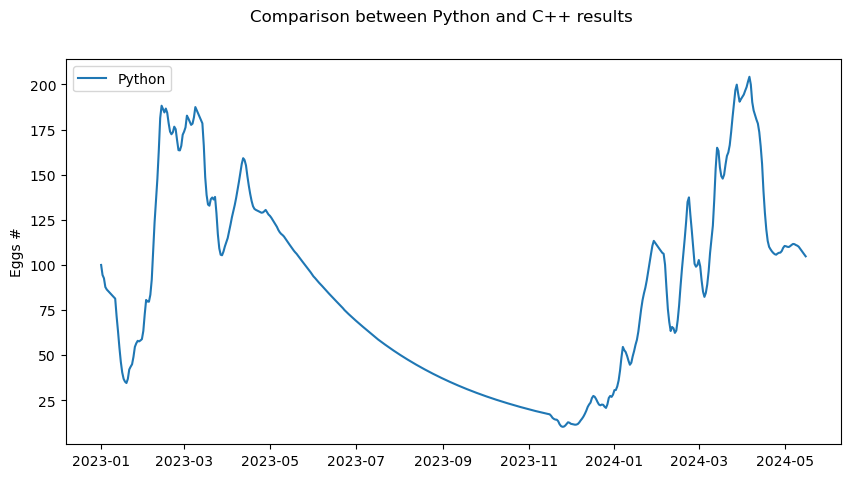

In [29]:
fig, axs = plt.subplots(1,1,figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs.plot(df.index,df.E,label='Python')
axs.legend()
axs.set_ylabel('Eggs #')

Text(0, 0.5, 'Adults #')

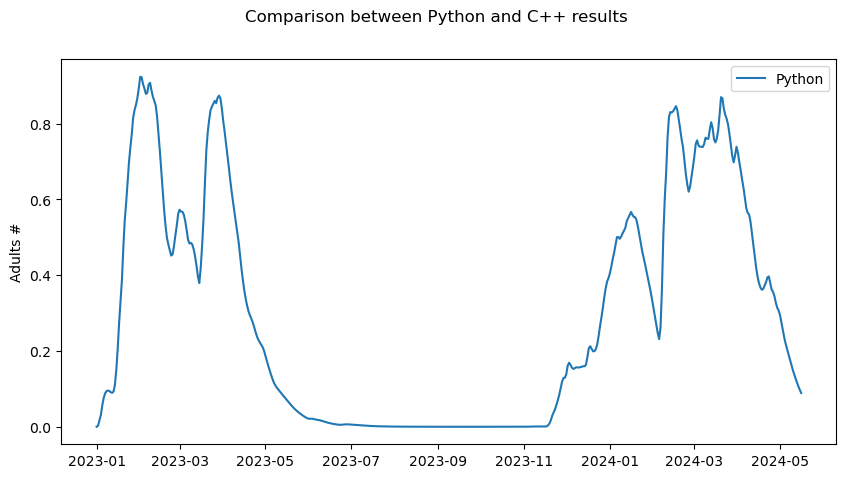

In [30]:
fig, axs = plt.subplots(1,1,figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs.plot(df.index,df.A,label='Python')
axs.legend()
axs.set_ylabel('Adults #')

Text(0, 0.5, 'Larvae #')

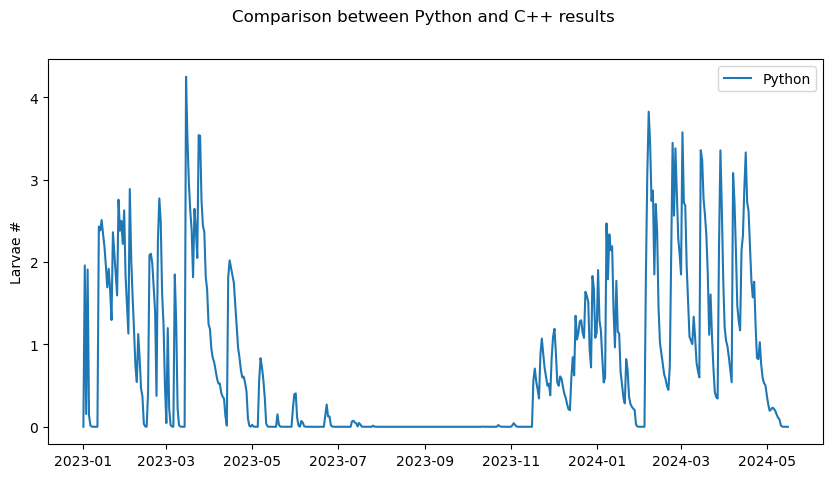

In [31]:
fig, axs = plt.subplots(1,1,figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs.plot(df.index,df.L,label='Python')
axs.legend()
axs.set_ylabel('Larvae #')

In [32]:
# Comparación con el modelo c++
df1 = pd.read_csv("results_cpp.csv",index_col=0)
df1.index = pd.to_datetime(df1.index)

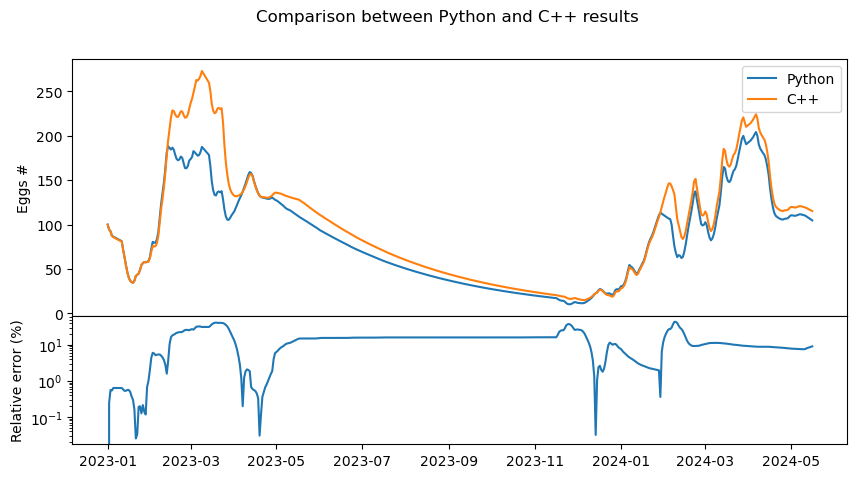

In [33]:
fig, axs = plt.subplots(2,1,height_ratios=[2,1],figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs[0].plot(df.index,df.E,label='Python')
axs[0].plot(df1.index,df1.E,label='C++')
axs[0].legend()
axs[0].set_ylabel('Eggs #')

axs[1].plot(df.index,np.abs((df.E - df1.E)/df1.E)*100)
axs[1].semilogy();
axs[1].set_ylabel('Relative error (%)');

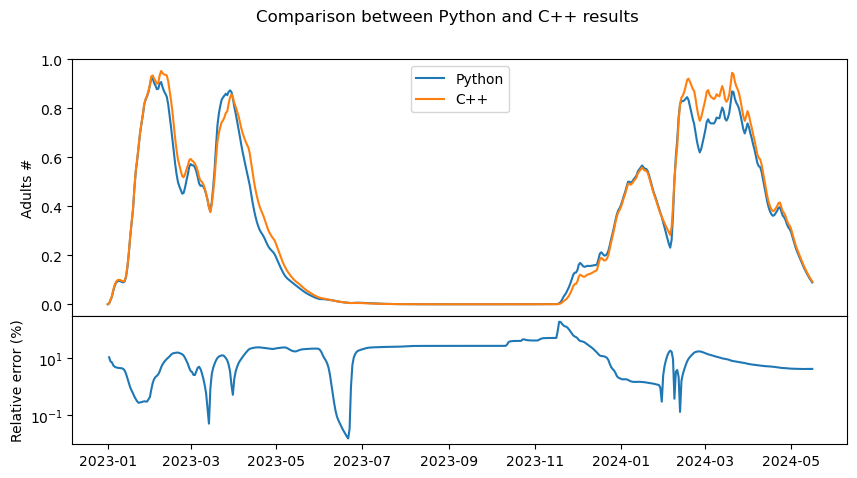

In [34]:
fig, axs = plt.subplots(2,1,height_ratios=[2,1],figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs[0].plot(df.index,df.A,label='Python')
axs[0].plot(df1.index,df1.A,label='C++')
axs[0].legend()
axs[0].set_ylabel('Adults #')

axs[1].plot(df.index,np.abs((df.A - df1.A)/df1.A)*100)
axs[1].semilogy();
axs[1].set_ylabel('Relative error (%)');

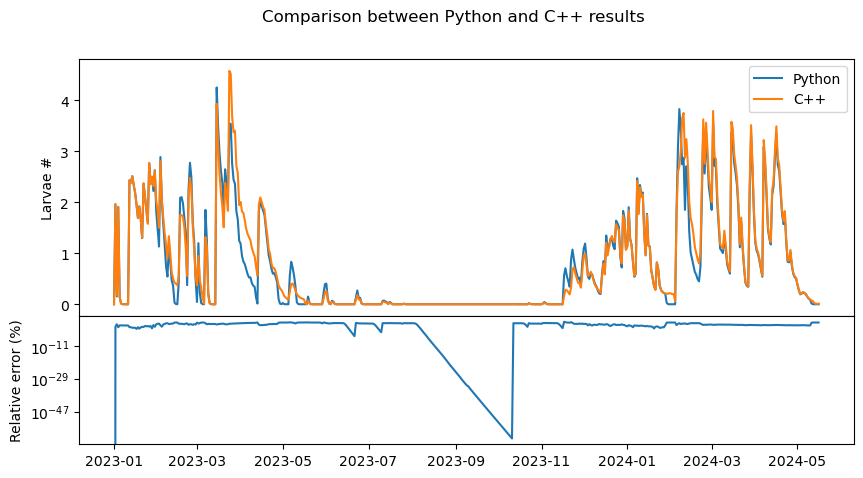

In [35]:
fig, axs = plt.subplots(2,1,height_ratios=[2,1],figsize=(10,5),sharex=True)
fig.subplots_adjust(hspace=0.0)

fig.suptitle('Comparison between Python and C++ results')

axs[0].plot(df.index,df.L,label='Python')
axs[0].plot(df1.index,df1.L,label='C++')
axs[0].legend()
axs[0].set_ylabel('Larvae #')

axs[1].plot(df.index,np.abs((df.L - df1.L)/(df1.L+1.e-10))*100)
axs[1].semilogy();
axs[1].set_ylabel('Relative error (%)');